# Variational AutoEncoder (VAE)

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import numpy as np
import matplotlib.pyplot as plt

## VAE model

In [15]:
IMG_SHAPE = (28, 28, 1)
LATENT_DIM = 128
KERNEL_SIZE = 4

# Encode the image into the latent space of dimension LATENT_DIM
def build_encoder(conditional=False, num_classes=10):
    inputs = Input(shape=IMG_SHAPE)
    x = layers.Conv2D(32, KERNEL_SIZE, strides=2, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(64, KERNEL_SIZE, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, KERNEL_SIZE, strides=2, padding='same', activation='relu')(x)
    x = layers.Flatten()(x)

    if conditional:
        labels = Input(shape=(num_classes,))
        x = layers.Concatenate()([x, labels])

    z_mean = layers.Dense(LATENT_DIM)(x)
    z_log_var = layers.Dense(LATENT_DIM)(x)
    return Model([inputs, labels], [z_mean, z_log_var], name='encoder')

In [3]:
# Sample from latent space the vector z = mean + sqrt(exp(log_var)) * epsilon
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [13]:
# Decode from the latent space the original image
def build_decoder(conditional=False, num_classes=10):
  latent_inputs = Input(shape=(LATENT_DIM,))
  if conditional:
    labels = Input(shape=(num_classes,))
    concat_inputs = layers.Concatenate()([latent_inputs, labels])

  x = layers.Dense(7 * 7 * LATENT_DIM, activation='relu')(concat_inputs if conditional else latent_inputs)
  x = layers.Reshape((7, 7, LATENT_DIM))(x)
  x = layers.Conv2DTranspose(64, KERNEL_SIZE, strides=2, padding='same', activation='relu')(x)
  x = layers.Conv2DTranspose(32, KERNEL_SIZE, strides=2, padding='same', activation='relu')(x)
  outputs = layers.Conv2D(1, KERNEL_SIZE-1, padding='same', activation='sigmoid')(x)
  return Model([latent_inputs, labels], outputs, name='decoder')

In [21]:
# VAE class that has an encoder, a sampler, a decoder and the VAE loss
class VAE(Model):

  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.sampler = Sampling()
    self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")

  def compile(self, optimizer):
    super().compile()
    self.optimizer = optimizer
    self.recon_loss_fn = tf.keras.losses.MeanSquaredError()

  def train_step(self, data):
    data, label = data[0]

    with tf.GradientTape() as tape:
      z_mean, z_log_var = self.encoder([data, label])
      z = self.sampler([z_mean, z_log_var])
      decoded_image = self.decoder([z, label])
      loss = self.vae_loss(data, decoded_image, (z_mean, z_log_var))

    grads = tape.gradient(loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    self.total_loss_tracker.update_state(loss)
    return {
      "loss": self.total_loss_tracker.result()
    }

  def vae_loss(self, data, decoded_image, encoder_output):
    gamma = 0.0001
    z_mean, z_log_var = encoder_output
    recon_loss = (self.recon_loss_fn(data, decoded_image))
    kl_loss = -0.5 * tf.keras.backend.sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    return recon_loss + gamma * kl_loss

## Data preparation

In [6]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


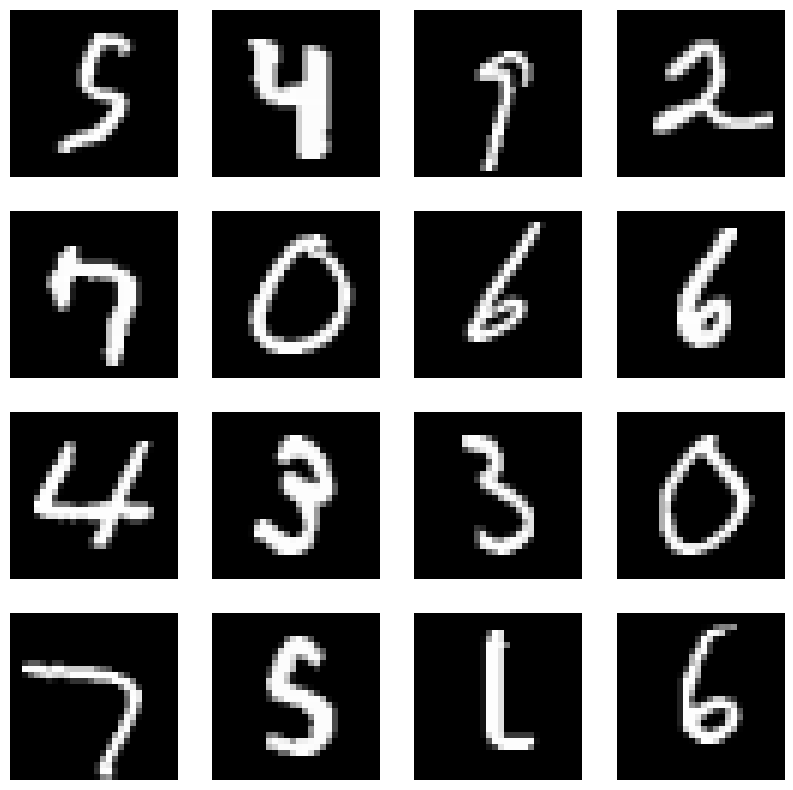

In [7]:
indices = np.random.choice(len(x_train), 16, replace=False)
images = x_train[indices]

plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i], cmap="gray")
    plt.axis("off")
plt.show()

## Training

In [8]:
encoder = build_encoder()
decoder = build_decoder()
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-3))

vae.fit(
    x_train,
    batch_size=64,
    epochs=30
)

Epoch 1/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.0536
Epoch 2/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0152
Epoch 3/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0126
Epoch 4/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0118
Epoch 5/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0114
Epoch 6/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0111
Epoch 7/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0109
Epoch 8/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0107
Epoch 9/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0106
Epoch 10/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0105
Epoch 11/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0104
Epoch 12/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0103
Epoch 13/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0102
Epoch 14/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0101
Epoch 15/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 6m

## Testing

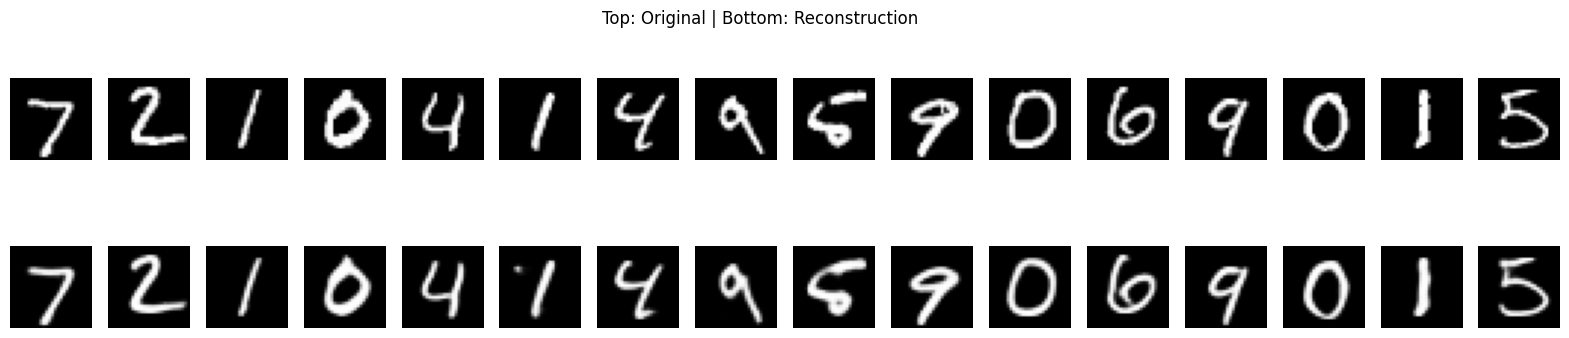

In [9]:
# Show real images reconstruction

real_images = x_test[:16]

z_mean, z_log_var = vae.encoder(real_images)
z = vae.sampler([z_mean, z_log_var])
recon_images = vae.decoder(z)

# Plot
n = len(real_images)
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(real_images[i], cmap="gray")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_images[i], cmap="gray")
    plt.axis("off")

plt.suptitle("Top: Original | Bottom: Reconstruction")
plt.show()

In [32]:
def get_labels_from_one_hots(one_hots):
  return np.argmax(one_hots, axis=1)

def sample_and_plot(decoder, n=10, label=None):
    z_random = tf.random.normal(shape=(n, LATENT_DIM))
    if label is not None:
      generated = decoder.predict([z_random, label])
    else:
      generated = decoder.predict(z_random)

    num_labels = get_labels_from_one_hots(label)
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(generated[i], cmap="gray")
        if label is not None:
          plt.title(num_labels[i])
        plt.axis("off")
    plt.suptitle("Randomly Generated Images")
    plt.show()

In [ ]:
sample_and_plot(vae.decoder)

# Conditional VAE

## Label one-hot encoding

## Training

In [11]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
ohe.fit(y_train.reshape(-1, 1))
y_train_one_hot = ohe.transform(y_train.reshape(-1, 1)).toarray()
y_test_one_hot = ohe.transform(y_test.reshape(-1, 1)).toarray()
y_train_one_hot.shape

(60000, 10)

In [30]:
params= {
    "conditional": True
}
cond_encoder = build_encoder(**params)
cond_decoder = build_decoder(**params)
cvae = VAE(encoder, decoder)
cvae.compile(optimizer=tf.keras.optimizers.Adam(1e-3))

cvae.fit(
    [x_train, y_train_one_hot],
    batch_size=64,
    epochs=30
)

Epoch 1/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.0092
Epoch 2/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 0.0092
Epoch 3/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0092
Epoch 4/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0091
Epoch 5/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0091
Epoch 6/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0091
Epoch 7/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0091
Epoch 8/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0090
Epoch 9/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0090
Epoch 10/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0090
Epoch 11/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0090
Epoch 12/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0090
Epoch 13/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0089
Epoch 14/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0089
Epoch 15/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step

## Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


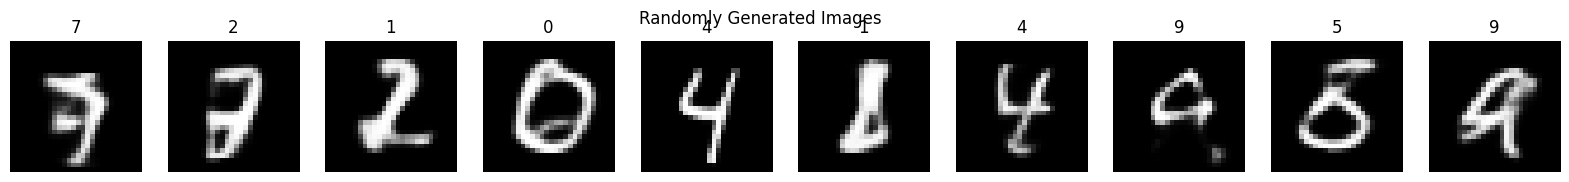

In [35]:
sample_and_plot(cvae.decoder, label=y_test_one_hot[:10])

## Visualization of CVAE latent space

In [47]:
from sklearn.decomposition import PCA

latent_space, variances = cond_encoder.predict([x_test, y_test_one_hot])
pca = PCA(n_components=2)
xs, ys = pca.fit_transform(latent_space).T

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


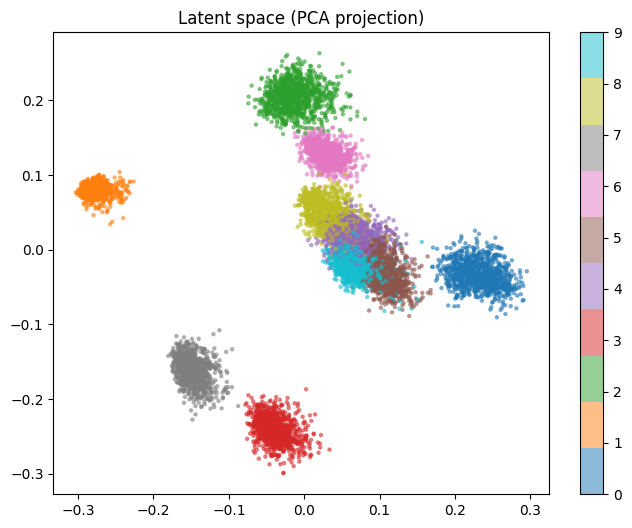

In [58]:
plt.figure(figsize=(8, 6))
plt.scatter(xs, ys, c=y_test, cmap="tab10", alpha=0.5, s=5)
plt.colorbar()
plt.title("Latent space (PCA projection)")
plt.show()